# Notebook Description

This notebook will focus on creating a Department Classifier, based on cart input data.

The investigation will begin by predicting Department affinity, assuming that the cart is _empty_. Later, 

# Initialize

## Imports

In [64]:
import math
import random
import pandas as pd
import numpy as np
import itertools as IT

import os
import sys

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix 
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

# Classification Models
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Load Subset of Data into Pandas Dataframe

In [16]:
df_aisle_index = pd.read_csv('../data/instacart-market-basket-analysis/aisles.csv')
print(df_aisle_index.shape)
df_dept_index = pd.read_csv('../data/instacart-market-basket-analysis/departments.csv')
print(df_dept_index.shape)
df_prod_index = pd.read_csv('../data/instacart-market-basket-analysis/products.csv')
print(df_prod_index.shape)

(134, 2)
(21, 2)
(49688, 4)


## Load Order Log, and Order Products

In [17]:
# define subset of data
# Take a sample of the 10,000 users represented in the data

# randomized version
# np.random.seed(4444)
# user_sample_list = np.random.choice(a=range(1,10000,1), size=300, replace=False)

user_subset = range(1,501, 1)

print('generated user subset of size: ', len(user_subset))

# Create a generalized mask that filters rows
# which are not applicable to the sampled users.
#
# masked_df = pd.DataFrame(
#     columns=['user_id']
# )
#
# user_mask = ([
#     (masked_df.user_id.isin(user_sample_list))
# ])

df_orders_log = pd.DataFrame(
    columns=['order_id','user_id','eval_set','order_number',
             'order_dow','order_hour_of_day','days_since_prior_order']
)

# import the orders csv in chunks
# filter out rows that aren't from the user sample
# concatenate to the prior/train dataset


def valid_user(chunks):
    for chunk in chunks:
        mask = chunk.user_id.isin(user_subset)
        yield chunk.loc[mask]

generated user subset of size:  500


In [18]:
# read in orders
filename = '../data/instacart-market-basket-analysis/orders.csv'
chunksize = 10 ** 4
chunks = pd.read_csv(filename, chunksize=chunksize)
df_orders_log = pd.concat(valid_user(chunks))

print(sys.getsizeof(df_orders_log)/1000000,'MB vs ',
      os.stat('../data/instacart-market-basket-analysis/orders.csv').st_size//1000000,'MB')

0.960604 MB vs  108 MB


In [19]:
# compile a list of unique orders that originate from our user sample

orders_subset = df_orders_log.order_id.unique()
print(orders_subset.shape)

def valid_order(chunks):
    for chunk in chunks:
        mask = chunk.order_id.isin(orders_subset)
        yield chunk.loc[mask]

(8142,)


In [20]:
df_order_prods__prior = pd.DataFrame(
    columns=['order_id','product_id','add_to_cart_order','reordered']
)

# import the prior/train_products csv in chunks
# filter out rows that aren't from the user sample
# concatenate to the prior/train dataset



# read in order_prods_prior
filename = '../data/instacart-market-basket-analysis/order_products__prior.csv'
chunksize = 10 ** 4
chunks = pd.read_csv(filename, chunksize=chunksize)
df_order_prods__prior = pd.concat(valid_order(chunks))

print(sys.getsizeof(df_order_prods__prior)/1000000,'MB vs ',
      os.stat('../data/instacart-market-basket-analysis/order_products__prior.csv').st_size//1000000,'MB')
print(df_order_prods__prior.shape)

3.097032 MB vs  577 MB
(77425, 4)


In [21]:
df_order_prods__train = pd.DataFrame(
    columns=['order_id','product_id','add_to_cart_order']
)

# import the prior/train_products csv in chunks
# filter out rows that aren't from the user sample
# concatenate to the prior/train dataset

# read in order_prods_prior
filename = '../data/instacart-market-basket-analysis/order_products__train.csv'
chunksize = 10 ** 4
chunks = pd.read_csv(filename, chunksize=chunksize)
df_order_prods__train = pd.concat(valid_order(chunks))

print(sys.getsizeof(df_order_prods__train)/1000000,'MB vs ',
      os.stat('../data/instacart-market-basket-analysis/order_products__train.csv').st_size//1000000,'MB')

0.135472 MB vs  24 MB


# Model Evaluation Schema - Department / Aisle Predictor

The goal of the Department / Aisle Predictor is to predict the distribution of the cart as closely as possible. This model will be used as part of a preliminary step towards predicting specific products. A model that successfully predicts the aisle a given user will begin shopping in would obviously be more useful to a product recommender than prediction of a specific aisle. However, that level of specificity may come at the cost of an overfit model. 

However, since the Cart Completer can only offer 5-10 slots for products, it may be more valuable to train Department / Aisle Predictor to find the distribution of the _first 5-10_ products. For large carts, the distribution of departments at the top of cart may very well be different than the distribution of products. Once we have a model that can predict the department/aisle for an empty cart, we can build features for a model that will predict departments for the remainder of the cart.

Though for partially completed carts, it may be advantageous to switch to a model that focuses on product-to-product associations, and uses items in the cart to infer user intent. So perhaps the Department/Aisle Predictor is only active for empty carts, then drops out once the user has confirmed specific intent upon adding the first item to their cart.

For the Department / Aisle Predictor, a custom performance metric is required. If our classifier returns a probability distribution for the departments/aisles of a given cart.

In [22]:
def EvaluateDepartmentPredictionError(pred_proba, actual_dist, method='Euclidean',
                                      cart_est_depth=5, voting_thresh=0.5):
    '''
    
    Custom distance metric to evaluate the error of the Department Predictor.
    
    The Department Predictor will return a set of probabilities
    representing the predicted distribution of departments.
    
    pred_prob represents a probability distribution for departments of
    products in the remainder of the user's cart, sorted by department_id.
    
    cart_est_depth represents the scope of the Predictor's estimation.
    
    If cart_est_depth=1, then the Predictor is only scored on the department
    of the next product. The highest likelihood department is used as the guess.
    
    An more intuitive problem however, is to estimate the distribution of the
    cart at least 5 products deep. If cart_est_depth==5, then the model is scored
    on its closeness to the department distribution of the next 5 items.
    
    Even if less than cart_est_depth items remain, if the Predictor guesses
    at least as many instances of the cart 
    
    This set of continuous, predicted distributions will be converted into
    integer counts of departments, rounding in favor of the
    department with the highest likelihood.
    
    e.g. if pred_prob = [0.3, 0.08, 0.1, 0.15, 0.02, (...), 0.2]
    where the n-th element is the predicted prob of items in department n.
     
    and (cart_est_depth == 5), then this function will first convert pred_prob
    to 5 department predictions.

    Error Schema 1: Euclidean Distance from Actual Distribution
    
    Return the Euclidean Distance of the pred_proba from actual_dist.
    
    Error Schema 2: "Voting"
    
    The voting method currently implemented relies on a "super-majority."
    voting_thresh is the sum of probabilities required to form a set of
    predicted integer counts of departments.

    Given a set of department probabilities, take the minimum top
    departments whose probabilities meet or exceed the voting_thresh amount.

    Supposing voting_thresh=0.6, the minimum set of departments would be
    (department_1, 0.3)
    (department_14,0.2)
    (department_4, 0.15)

    The total probabilities sum to 0.65, which just exceeds the voting_thresh.

    These soft probabilities are then used to proportionately determine the distribution
    of departments, rounding up in favor of the most popular departments.
    
    0.3/0.6 = 0.5; 0.5*(cart_est_depth=5) = 2.5; math.ceil(2.5) = 3; dept_1 gets 3 votes.
    0.2/0.6 = 0.33, 0.33*5 = 1.65, ceil(1.65)=2  --> dept_14 receives 2 votes.
    
    No votes remain for dept_4 (sum of votes so far = 5).
    
    Hard predictions are now as follows:
    
    preds_hard = np.array([3, 0, 0, (...), 0, 2], dtype=int8)
    where the n-th element in the list is the predicted amount of items in department n.
    
    If the actual distribution of the next 5 items in the cart is 
    actuals = [2, 1, 0, (...), 0,  2]

    Error is then calculated based on % Recall of the actual department classes.
    This accounts for cases in which sum(actuals) < cart_est_depth.
    
    residuals = (actuals - preds_hard)
    error = residuals[residuals > 0].sum()
    
    
    '''
    
    assert len(pred_proba) == len(actual_dist)
    
    mae = []
    
    for i in range(0, len(pred_proba), 1):
        
        pred = pred_proba[i]
        actual = np.array(actual_dist)[i]
        
        if method=='Euclidean':
            residuals = actual - pred
            mae += [np.sum(abs(residuals))]
    
    return np.mean(mae)
    

### Simulate Dynamic Department / Aisle Recommendation

In [23]:
def SimulateDynamicRec(order_rows, model, verbose=False):
    
    assert type(order_rows) == type(pd.DataFrame())
    cart = set([])
    
    order_rows = order_rows.sort_values('add_to_cart_order')
    
    if verbose:
        print('testing the following order:\n', order_rows)
    
    total = 0
    guessed = 0
    
    # progress through order one at a time
    for index, row in order_rows.iterrows():
        
        ### Recommend 5 New Products ###
        
        try:
            #### CHECK MODEL TYPE #####
            model_type = model.type
#             print('model type is: ', model_type)
            if model_type in ['naive','reordered']:
                recommendations = model.top100
            
            
            # Exclude items already in cart.
            rec5 = random.sample((recommendations - cart), 5)
            
        except:
            #### OTHER MODELS #####
            pass
        
        
        total += 1
        success = False
        
        actual_next = row['product_id']
        
        if actual_next in rec5:
            success = True
            guessed += 1
        
        # debug output
        if verbose:
#             print(f'Cart is {cart}.\nRecommending {rec5}.')
            if success:
                print(f'Guessed {actual_next}!\n')
                continue
            else:
#                 print(f'Oops, {actual_next} wasn\'t in recommendation list.')
                continue
        
        cart.add(actual_next)
    
    # rel_pct = % of trials where recommendations were relevant to next purchase.
    rel_pct = guessed/total
    
    if verbose:
        print(f'Got {rel_pct}% right of {total}.')
    
    return rel_pct

In [24]:
def DynamicRecScore(model, trials = 100):

    relevancies = []
    
    unique_train_orders = set(df_order_prods__train.order_id.unique())
#     print(len(unique_train_orders))
    
    # If there aren't enough training datapoints.
    if trials > len(unique_train_orders):
        trials = len(unique_train_orders)
    
    for order_id in random.sample(unique_train_orders, trials):
        
#         test_order = df_order_prods__train.sample().order_id.values[0]

        test_order_rows = df_order_prods__train[df_order_prods__train.order_id == order_id]
        rel_pct = SimulateDynamicRec(test_order_rows, model,verbose=False)
        relevancies += [rel_pct]
        
    return np.mean(relevancies)

# Merge, Append Aisle/Department Columns to Order Log

In [25]:
# Confirm we haven't merged in duplicate columns from re-running this script.
df_order_prods__prior = df_order_prods__prior[['order_id','product_id','add_to_cart_order','reordered']]

df_order_prods__prior = pd.merge(
    df_order_prods__prior,
    df_prod_index.drop(labels='product_name',axis=1), on='product_id')

# Confirm we haven't merged in duplicate columns from re-running this script.
df_order_prods__train = df_order_prods__train[['order_id','product_id','add_to_cart_order','reordered']]

df_order_prods__train = pd.merge(
    df_order_prods__train,
    df_prod_index.drop(labels='product_name',axis=1), on='product_id')

In [26]:
# validate correct columns have been added
# should see ['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'aisle_id', 'department_id']
df_order_prods__prior.sample(3)

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id
12611,1710899,47890,7,1,123,4
59749,2933864,8197,6,1,31,7
61919,2302602,40723,3,1,24,4


# Add Department Labels to Order Log

In [27]:
df_order_prods__prior = pd.merge(
    df_order_prods__prior,
    df_dept_index, on='department_id'
)
df_order_prods__train  = pd.merge(
    df_order_prods__train,
    df_dept_index, on='department_id'
)

In [28]:
# should see department name as well
df_order_prods__prior.head(1)

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,department
0,40,10070,1,1,84,16,dairy eggs


# Merge Order Log Information to order_prods__SET

In [29]:
# Merge in time-based information to the order_prods__prior
df_order_prods__prior = pd.merge(
    df_order_prods__prior, df_orders_log, on='order_id'
)

In [30]:
df_order_prods__prior.head(2)

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,40,10070,1,1,84,16,dairy eggs,382,prior,29,1,15,23.0
1,40,34866,4,1,84,16,dairy eggs,382,prior,29,1,15,23.0


In [31]:
# same for train
df_order_prods__train = pd.merge(
    df_order_prods__train, df_orders_log, on='order_id'
)

In [32]:
df_order_prods__train.head(2)

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,988,45061,1,0,37,1,frozen,310,train,100,2,9,4.0
1,988,28464,2,0,53,16,dairy eggs,310,train,100,2,9,4.0


# One-Hot Encode Day of Week

In [33]:
df_order_prods__prior = pd.get_dummies(df_order_prods__prior, prefix='dow_', columns=['order_dow'])
df_order_prods__train = pd.get_dummies(df_order_prods__train, prefix='dow_', columns=['order_dow'])

### Rename DOW columns

After investigation, dow_0 probably represents Saturday.

In [34]:
df_order_prods__prior.rename(columns={
    'dow__0':'Sat',
    'dow__1':'Sun',
    'dow__2':'Mon',
    'dow__3':'Tues',
    'dow__4':'Weds',
    'dow__5':'Thur',
    'dow__6':'Fri',
}, inplace=True)

df_order_prods__train.rename(columns={
    'dow__0':'Sat',
    'dow__1':'Sun',
    'dow__2':'Mon',
    'dow__3':'Tues',
    'dow__4':'Weds',
    'dow__5':'Thur',
    'dow__6':'Fri',
}, inplace=True)

In [35]:
list(df_order_prods__prior.columns)

['order_id',
 'product_id',
 'add_to_cart_order',
 'reordered',
 'aisle_id',
 'department_id',
 'department',
 'user_id',
 'eval_set',
 'order_number',
 'order_hour_of_day',
 'days_since_prior_order',
 'Sat',
 'Sun',
 'Mon',
 'Tues',
 'Weds',
 'Thur',
 'Fri']

# Basic MultiClass Models, No User Features

Train on `__prior` and then test on `__train`

In [36]:
# Impute first orders with -99 to create significant distance for clustering.
df_order_prods__prior.days_since_prior_order =  df_order_prods__prior.days_since_prior_order.fillna(value=-99)

In [37]:
feature_cols = ([
#     'order_id',
#     'product_id',
    'add_to_cart_order',
    'reordered',
#     'aisle_id',
#     'department_id',
#     'user_id',
#     'eval_set',
#     'order_number',
    'order_hour_of_day',
    'days_since_prior_order',
#     'department',
    'Sat',
    'Sun',
    'Mon',
    'Tues',
    'Weds',
    'Thur',
    'Fri']
)

X_train = df_order_prods__prior[feature_cols]
y_train = df_order_prods__prior['department']

In [38]:
# If we don't include cart features (like the last product added, then our testing dataframe needs to )

X_test = df_order_prods__train[feature_cols]
y_test = df_order_prods__train['department']

In [39]:
df_order_prods__train.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'aisle_id',
       'department_id', 'department', 'user_id', 'eval_set', 'order_number',
       'order_hour_of_day', 'days_since_prior_order', 'Sat', 'Sun', 'Mon',
       'Tues', 'Weds', 'Thur', 'Fri'],
      dtype='object')

### Add Columns Describing Departments of Entire Cart, The Last Cart Item, and the Remaining Cart

In [40]:
# For each dataset, we need to collect the entire cart, as a list of departments.
# Then, will re-merge this into the orders dataframe.

full_cart_depts__train = df_order_prods__train.groupby(by='order_id')['department_id'].apply(list).reset_index(name='full_cart')
full_cart_depts__prior = df_order_prods__prior.groupby(by='order_id')['department_id'].apply(list).reset_index(name='full_cart')

full_cart_depts__train.head()

,order_id,full_cart
0,988,"[1, 16, 17, 2]"
1,3529,"[18, 18]"
2,13318,"[4, 4, 4, 4, 4, 4, 19, 19, 12]"
3,14172,"[1, 16, 16, 16, 4, 4, 12, 12, 7, 7, 7, 3]"
4,15694,[9]


In [41]:
df_order_prods__prior = pd.merge(df_order_prods__prior, full_cart_depts__prior, on='order_id')
df_order_prods__train = pd.merge(df_order_prods__train, full_cart_depts__train, on='order_id')

In [42]:
# Create a column for the "cart remaining", a slice of the full_cart
# according what part of the cart has already been added.
# e.g. If add_to_cart_order == 1, keep the whole cart.
# inverse for 'cart_seen'

df_order_prods__prior['cart_remain'] = df_order_prods__prior.apply(lambda row: row['full_cart'][row['add_to_cart_order'] - 1:], axis=1)
df_order_prods__prior['cart_seen'] = df_order_prods__prior.apply(lambda row: row['full_cart'][:row['add_to_cart_order'] - 1], axis=1)
df_order_prods__prior.head(2)

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,department,user_id,eval_set,order_number,...,Sat,Sun,Mon,Tues,Weds,Thur,Fri,full_cart,cart_remain,cart_seen
0,40,10070,1,1,84,16,dairy eggs,382,prior,29,...,0,1,0,0,0,0,0,"[16, 16, 1, 7]","[16, 16, 1, 7]",[]
1,40,34866,4,1,84,16,dairy eggs,382,prior,29,...,0,1,0,0,0,0,0,"[16, 16, 1, 7]",[7],"[16, 16, 1]"


In [43]:
df_order_prods__train['cart_remain'] = df_order_prods__train.apply(lambda row: row['full_cart'][row['add_to_cart_order'] - 1:], axis=1)
df_order_prods__train['cart_seen'] = df_order_prods__train.apply(lambda row: row['full_cart'][:row['add_to_cart_order'] - 1], axis=1)

In [44]:
# Given a cart distribution (remaining, or current),
# write a function to return the distribution at that state

def get_cart_distribution(cart_list):
    
    cart_dist = np.zeros(21)
    
    if len(cart_list)==0:
        return cart_dist
    
    cart_count = Counter(cart_list)
    
    for elem, cnt in cart_count.items():
        cart_dist[elem-1] = cnt
    cart_dist = cart_dist/sum(cart_dist)

    return cart_dist

def get_cart_counts(cart_list):
    
    cart_dist = np.zeros(21)
    
    if len(cart_list)==0:
        return cart_dist
    
    cart_count = Counter(cart_list)
    
    for elem, cnt in cart_count.items():
        cart_dist[elem-1] = cnt
    cart_dist = cart_dist

    return cart_dist

In [45]:
# cart_remain_cols = ['rem_dept_' + str(i) + '_dst' for i in range(1, 22,1)]
cart_seen_cols = ['curr_dept_' + str(i) + '_cts' for i in range(1, 22,1)]

In [46]:
# cart_remain_dists = pd.DataFrame(df_order_prods__prior.cart_remain.apply(get_cart_distribution).tolist(), columns=cart_remain_cols)
cart_seen_dists = pd.DataFrame(df_order_prods__prior.cart_seen.apply(get_cart_counts).tolist(), columns=cart_seen_cols)
df_order_prods__prior[cart_seen_cols] = cart_seen_dists[cart_seen_cols]
df_order_prods__prior.head()

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,department,user_id,eval_set,order_number,...,curr_dept_12_cts,curr_dept_13_cts,curr_dept_14_cts,curr_dept_15_cts,curr_dept_16_cts,curr_dept_17_cts,curr_dept_18_cts,curr_dept_19_cts,curr_dept_20_cts,curr_dept_21_cts
0,40,10070,1,1,84,16,dairy eggs,382,prior,29,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,40,34866,4,1,84,16,dairy eggs,382,prior,29,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
2,40,42450,2,1,38,1,frozen,382,prior,29,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,40,33198,3,1,115,7,beverages,382,prior,29,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
4,116744,10070,3,1,84,16,dairy eggs,382,prior,23,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0


In [413]:
df_order_prods__prior.describe()

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,user_id,order_number,order_hour_of_day,days_since_prior_order,...,curr_dept_12_dst,curr_dept_13_dst,curr_dept_14_dst,curr_dept_15_dst,curr_dept_16_dst,curr_dept_17_dst,curr_dept_18_dst,curr_dept_19_dst,curr_dept_20_dst,curr_dept_21_dst
count,7.742500e+04,77425.000000,77425.000000,77425.000000,77425.000000,77425.000000,77425.000000,77425.000000,77425.000000,77425.00000,...,77425.000000,77425.000000,77425.000000,77425.000000,77425.000000,77425.000000,77425.000000,77425.000000,77425.000000,77425.000000
mean,1.696186e+06,25815.593323,8.360452,0.583687,71.339244,10.010216,260.848576,16.878579,13.520052,4.11411,...,0.068156,0.297901,0.166174,0.034227,2.143920,0.048654,0.027201,0.798721,0.069073,0.000801
std,9.880130e+05,14216.871937,7.193211,0.492950,38.136164,6.247321,140.175786,17.531267,4.273775,28.13042,...,0.329567,0.980790,0.481257,0.308514,2.196407,0.337818,0.481615,1.647401,0.367711,0.042211
min,4.000000e+01,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,-99.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.567530e+05,13535.000000,3.000000,0.000000,31.000000,4.000000,149.000000,5.000000,10.000000,4.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.671477e+06,25740.000000,6.000000,1.000000,83.000000,9.000000,262.000000,11.000000,13.000000,7.00000,...,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.564286e+06,38293.000000,11.000000,1.000000,106.000000,16.000000,381.000000,23.000000,17.000000,14.00000,...,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,3.420572e+06,49683.000000,89.000000,1.000000,134.000000,21.000000,500.000000,99.000000,23.000000,30.00000,...,5.000000,13.000000,5.000000,8.000000,17.000000,8.000000,29.000000,21.000000,7.000000,5.000000


In [47]:
cart_seen_dists = pd.DataFrame(df_order_prods__train.cart_seen.apply(get_cart_counts).tolist(), columns=cart_seen_cols)
df_order_prods__train[cart_seen_cols] = cart_seen_dists[cart_seen_cols]

In [48]:
df_order_prods__train.describe()

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,user_id,order_number,order_hour_of_day,days_since_prior_order,...,curr_dept_12_cts,curr_dept_13_cts,curr_dept_14_cts,curr_dept_15_cts,curr_dept_16_cts,curr_dept_17_cts,curr_dept_18_cts,curr_dept_19_cts,curr_dept_20_cts,curr_dept_21_cts
count,3.386000e+03,3386.000000,3386.000000,3386.000000,3386.000000,3386.000000,3386.000000,3386.000000,3386.000000,3386.000000,...,3386.000000,3386.000000,3386.000000,3386.000000,3386.000000,3386.00000,3386.000000,3386.000000,3386.000000,3386.000000
mean,1.778419e+06,25502.752215,9.029829,0.619905,71.388069,9.977850,252.418193,17.689900,13.590077,16.622859,...,0.127880,0.202894,0.101004,0.025989,2.311577,0.21707,0.077082,0.505021,0.085647,0.002658
std,9.702635e+05,14223.877284,7.747301,0.485481,38.397940,6.279491,148.333922,17.184036,4.106954,10.103561,...,0.413805,0.911378,0.480478,0.241679,2.555516,0.60560,0.614180,1.094422,0.505556,0.061915
min,9.880000e+02,4.000000,1.000000,0.000000,1.000000,1.000000,1.000000,4.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,1.016866e+06,13176.000000,3.000000,0.000000,31.000000,4.000000,118.000000,7.000000,11.000000,7.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,1.854765e+06,25272.000000,7.000000,1.000000,83.000000,9.000000,238.000000,12.000000,13.000000,14.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,2.614670e+06,38178.500000,12.000000,1.000000,107.000000,16.000000,383.750000,22.000000,16.000000,30.000000,...,0.000000,0.000000,0.000000,0.000000,4.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,3.412247e+06,49683.000000,57.000000,1.000000,134.000000,21.000000,499.000000,100.000000,23.000000,30.000000,...,2.000000,9.000000,6.000000,4.000000,11.000000,5.00000,8.000000,7.000000,10.000000,2.000000


In [49]:
df_order_prods__prior['cart_seen_dist'] = df_order_prods__prior.cart_seen.apply(get_cart_distribution)
df_order_prods__train['cart_seen_dist'] = df_order_prods__train.cart_seen.apply(get_cart_distribution)

In [50]:
df_order_prods__prior['cart_remain_dist'] = df_order_prods__prior.cart_remain.apply(get_cart_distribution)
df_order_prods__train['cart_remain_dist'] = df_order_prods__train.cart_remain.apply(get_cart_distribution)

In [51]:
df_order_prods__prior.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'aisle_id',
       'department_id', 'department', 'user_id', 'eval_set', 'order_number',
       'order_hour_of_day', 'days_since_prior_order', 'Sat', 'Sun', 'Mon',
       'Tues', 'Weds', 'Thur', 'Fri', 'full_cart', 'cart_remain', 'cart_seen',
       'curr_dept_1_cts', 'curr_dept_2_cts', 'curr_dept_3_cts',
       'curr_dept_4_cts', 'curr_dept_5_cts', 'curr_dept_6_cts',
       'curr_dept_7_cts', 'curr_dept_8_cts', 'curr_dept_9_cts',
       'curr_dept_10_cts', 'curr_dept_11_cts', 'curr_dept_12_cts',
       'curr_dept_13_cts', 'curr_dept_14_cts', 'curr_dept_15_cts',
       'curr_dept_16_cts', 'curr_dept_17_cts', 'curr_dept_18_cts',
       'curr_dept_19_cts', 'curr_dept_20_cts', 'curr_dept_21_cts',
       'cart_seen_dist', 'cart_remain_dist'],
      dtype='object')

In [52]:
df_order_prods__prior.describe()

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,user_id,order_number,order_hour_of_day,days_since_prior_order,...,curr_dept_12_cts,curr_dept_13_cts,curr_dept_14_cts,curr_dept_15_cts,curr_dept_16_cts,curr_dept_17_cts,curr_dept_18_cts,curr_dept_19_cts,curr_dept_20_cts,curr_dept_21_cts
count,7.742500e+04,77425.000000,77425.000000,77425.000000,77425.000000,77425.000000,77425.000000,77425.000000,77425.000000,77425.00000,...,77425.000000,77425.000000,77425.000000,77425.000000,77425.000000,77425.000000,77425.000000,77425.000000,77425.000000,77425.000000
mean,1.696186e+06,25815.593323,8.360452,0.583687,71.339244,10.010216,260.848576,16.878579,13.520052,4.11411,...,0.068156,0.297901,0.166174,0.034227,2.143920,0.048654,0.027201,0.798721,0.069073,0.000801
std,9.880130e+05,14216.871937,7.193211,0.492950,38.136164,6.247321,140.175786,17.531267,4.273775,28.13042,...,0.329567,0.980790,0.481257,0.308514,2.196407,0.337818,0.481615,1.647401,0.367711,0.042211
min,4.000000e+01,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,-99.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.567530e+05,13535.000000,3.000000,0.000000,31.000000,4.000000,149.000000,5.000000,10.000000,4.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.671477e+06,25740.000000,6.000000,1.000000,83.000000,9.000000,262.000000,11.000000,13.000000,7.00000,...,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.564286e+06,38293.000000,11.000000,1.000000,106.000000,16.000000,381.000000,23.000000,17.000000,14.00000,...,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,3.420572e+06,49683.000000,89.000000,1.000000,134.000000,21.000000,500.000000,99.000000,23.000000,30.00000,...,5.000000,13.000000,5.000000,8.000000,17.000000,8.000000,29.000000,21.000000,7.000000,5.000000


## Model Selection

In [53]:
# columns that include prior distribution of cart:

cart_dist_feature_cols = (
    [
#         'order_id',
#         'product_id',
        'add_to_cart_order', 'reordered',
#         'aisle_id', 'department', 'user_id', 'eval_set',
        'order_number', 'order_hour_of_day', 'days_since_prior_order',
        'Sat', 'Sun', 'Mon', 'Tues', 'Weds', 'Thur', 'Fri',
#         'full_cart', 'cart_remain', 'cart_seen',
       'curr_dept_1_cts', 'curr_dept_2_cts', 'curr_dept_3_cts',
       'curr_dept_4_cts', 'curr_dept_5_cts', 'curr_dept_6_cts',
       'curr_dept_7_cts', 'curr_dept_8_cts', 'curr_dept_9_cts',
       'curr_dept_10_cts', 'curr_dept_11_cts', 'curr_dept_12_cts',
       'curr_dept_13_cts', 'curr_dept_14_cts', 'curr_dept_15_cts',
       'curr_dept_16_cts', 'curr_dept_17_cts', 'curr_dept_18_cts',
       'curr_dept_19_cts', 'curr_dept_20_cts', 'curr_dept_21_cts',
        'department_id'
    ]
)

In [54]:
X_train = df_order_prods__prior[cart_dist_feature_cols]
y_train = df_order_prods__prior['department']

In [55]:
X_test = df_order_prods__train[cart_dist_feature_cols]
y_test = df_order_prods__train['cart_remain_dist']

### Gaussian Naive Bayes

In [56]:
# Gaussian Naive Bayes

gnb = GaussianNB()
gnb.fit(X_train, y_train)
# accuracy = gnb.score(X_test, y_test) 
X_test_pred_proba = gnb.predict_proba(X_test)

cart_dept_error = EvaluateDepartmentPredictionError(X_test_pred_proba,y_test)

print('Gaussian Naive Bayes Cart Average MAE: ', cart_dept_error)
# gnb_preds = gnb.predict(X_test) 
# cm = confusion_matrix(y_test, gnb_preds)
# sns.heatmap(cm)

Gaussian Naive Bayes Cart Average MAE:  1.9087292932465354


### KNN

In [57]:
knn = KNeighborsClassifier(n_neighbors = 50)
knn.fit(X_train, y_train)

X_test_pred_proba = knn.predict_proba(X_test)
cart_dept_error = EvaluateDepartmentPredictionError(X_test_pred_proba,y_test)

print('KNN MAE / Distance: ', cart_dept_error)

KNN MAE / Distance:  1.7815693233816319


In [58]:
knn = KNeighborsClassifier(n_neighbors = 50, weights='distance')
knn.fit(X_train, y_train)

X_test_pred_proba = knn.predict_proba(X_test)
cart_dept_error = EvaluateDepartmentPredictionError(X_test_pred_proba,y_test)

print('KNN MAE / Distance: ', cart_dept_error)

KNN MAE / Distance:  1.7841653492328247


In [59]:
knn = KNeighborsClassifier(n_neighbors = 5, weights='distance')
knn.fit(X_train, y_train)

X_test_pred_proba = knn.predict_proba(X_test)
cart_dept_error = EvaluateDepartmentPredictionError(X_test_pred_proba,y_test)

print('KNN MAE / Distance: ', cart_dept_error)

KNN MAE / Distance:  1.8443506050353304


In [60]:
# KNN
knn_error = []
for n_neighbors in range(1,50):
    knn = KNeighborsClassifier(n_neighbors = n_neighbors)
    knn.fit(X_train, y_train)
    
#     accuracy = knn.score(X_test, y_test) 
#     print(f'KNN {n_neighbors} accuracy = ', accuracy)

    X_test_pred_proba = knn.predict_proba(X_test)
    cart_dept_error = EvaluateDepartmentPredictionError(X_test_pred_proba,y_test)
    
    knn_error += [[n_neighbors, cart_dept_error]]
                 

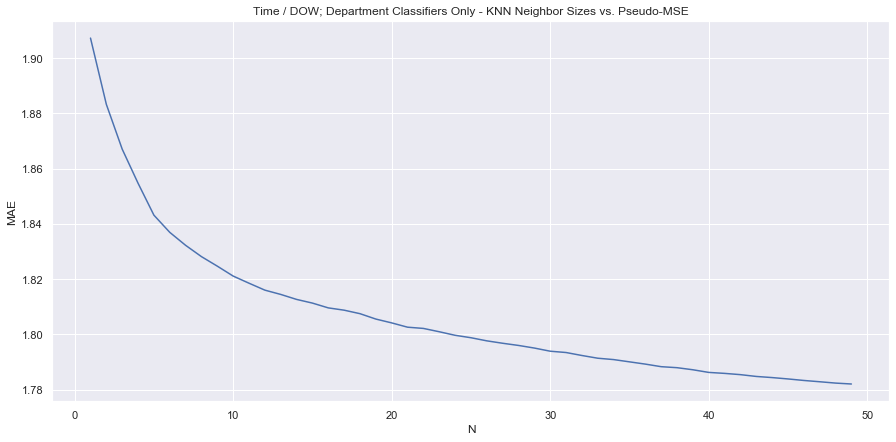

In [62]:
knn_error = pd.DataFrame(data=knn_error, columns=['N', 'MAE'])

fig, ax = plt.subplots(figsize=(15,7))
sns.lineplot(x='N', y='MAE', data=knn_error)
plt.title('Time / DOW; Department Classifiers Only - KNN Neighbor Sizes vs. Pseudo-MSE');

### Random Forest

In [67]:
rf_model = RandomForestClassifier(n_estimators=100, )
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [68]:
X_test_pred_proba = rf_model.predict_proba(X_test)
rf_error = EvaluateDepartmentPredictionError(X_test_pred_proba,y_test)
print(f'Random Forest MAE, trees={100}: ', rf_error)

Random Forest MAE, trees=100:  1.8080104106966122


### Decision Tree

In [379]:
for max_depth in range(1,15,1):
    dtree_model = DecisionTreeClassifier(max_depth = max_depth)
    dtree_model.fit(X_train, y_train) 
    #     dtree_preds = dtree_model.predict(X_test)
    X_test_pred_proba = dtree_model.predict_proba(X_test)
    dtree_error = EvaluateDepartmentPredictionError(X_test_pred_proba,y_test)

    print(f'Decision Tree MAE, depth {max_depth}: ', dtree_error)

Decision Tree MAE, depth 1:  1.7278634213247839
Decision Tree MAE, depth 2:  1.7986315964503814
Decision Tree MAE, depth 3:  1.859052972065118
Decision Tree MAE, depth 4:  1.8850958474385713
Decision Tree MAE, depth 5:  1.8992222716275087
Decision Tree MAE, depth 6:  1.9048307877570574
Decision Tree MAE, depth 7:  1.9050934905017614
Decision Tree MAE, depth 8:  1.9074173797100276
Decision Tree MAE, depth 9:  1.9087292932465514
Decision Tree MAE, depth 10:  1.9087292932465514
Decision Tree MAE, depth 11:  1.9087292932465514


KeyboardInterrupt: 

# User Profiles

## Initialize User Dataframe

In [73]:
# Create a users database with some historical information for each user

df_user_profs = pd.DataFrame()
df_user_profs['user_id'] = user_subset
# df_user_profs.set_index('user_id', inplace=True)
df_user_profs.head(3)

,user_id
0,1
1,2
2,3


## Generate High-level User Features

### User Order History : `order_id_history` (User)

In [74]:
def query_user_order_history(user_id, df_orders_log):
    '''
    
    Return an ordered list of tuples,
    e.g. [(1, order_id_1), ... , (latest_order_number, latest_order_id)]
    
    '''
    
    user_orders = df_orders_log[df_orders_log.user_id == user_id]
    
    return (user_orders[['order_number', 'order_id']]).to_numpy()
 

In [75]:
df_user_profs['order_id_history'] = df_user_profs.user_id.apply(
    query_user_order_history, df_orders_log=df_orders_log
)

In [27]:
df_user_profs.head(1)

,user_id,order_id_history
0,1,"[[1, 2539329], [2, 2398795], [3, 473747], [4, ..."


### Unique Order Count (User)

In [28]:
df_user_profs['num_orders'] = df_user_profs.order_id_history.apply(lambda x: len(x))
df_user_profs.head(2)

,user_id,order_id_history,num_orders
0,1,"[[1, 2539329], [2, 2398795], [3, 473747], [4, ...",11
1,2,"[[1, 2168274], [2, 1501582], [3, 1901567], [4,...",15


### Order Sizes (User)

In [29]:
(df_order_prods__prior[df_order_prods__prior.order_id == 2539329]
                              .groupby('order_id')
).agg('nunique')['product_id']

order_id
2539329    5
Name: product_id, dtype: int64

In [30]:
## Average Order Sizes by User ##

run_limit = 5
run_count = 0

def avg_user_order_sizes(order_id_history, df_order_prods):
    
#     global run_count
#     global run_limit
    
#     run_count += 1
#     if run_count > run_limit:
#         return 0

    
#     print(order_id_history)
    order_id_list = order_id_history[:,1]
#     print(order_id_list)
#     print(type(order_id_list))

    avg_order_size = (
        df_order_prods[df_order_prods.order_id.isin(order_id_list)]              
        .groupby('order_id')
        .agg('nunique')
    ).mean()['product_id']

#     print(avg_order_size)
    return avg_order_size

df_user_profs['avg_order_size'] = (df_user_profs.order_id_history
                                    .apply(avg_user_order_sizes, df_order_prods=df_order_prods__prior)
                                   )

df_user_profs.head()

,user_id,order_id_history,num_orders,avg_order_size
0,1,"[[1, 2539329], [2, 2398795], [3, 473747], [4, ...",11,5.900000
1,2,"[[1, 2168274], [2, 1501582], [3, 1901567], [4,...",15,13.928571
2,3,"[[1, 1374495], [2, 444309], [3, 3002854], [4, ...",13,7.333333
3,4,"[[1, 3343014], [2, 2030307], [3, 691089], [4, ...",6,3.600000
4,5,"[[1, 2717275], [2, 1909121], [3, 2267326], [4,...",5,9.250000


### Department Affinity – Occurence (User)

Calculate support for the total products ordered from each department_id.

In [80]:
df_order_prods__prior.groupby('user_id')['department_id'].value_counts()

user_id  department_id
1        19               22
         7                13
         16               13
         4                 5
         14                3
                          ..
500      16                4
         1                 3
         11                2
         13                1
         15                1
Name: department_id, Length: 5425, dtype: int64

In [33]:
def order_department_visits(user_id):
    '''
    
    Given an order_id, look up the order,
    and calculate the total number of visits to each department.
    Return a vector the length of the number of departments.
    
    '''
    
    product_list

SyntaxError: invalid syntax (<ipython-input-33-9bcb8f1ca6d2>, line 1)

In [31]:
# Create a dictionary with department IDs as keys
# each value is the number of unique department check-ins.
# i.e. An order with two products from the same department
# should count as 1 unique check-in.

user_hist['dept_dict'] = dict(zip(depts.department_id.values,0*depts.department_id.values))

def department(user_id, orders, order_prods, subset='prior'):
    
    user_orders = orders[(orders.user_id == user_id) & (orders.eval_set == subset)]
    
    gb_order = user_orders.groupby('order_id')
    
    
    
    for group in gb_order:
        
        
    
    
    return order_sizes


user_hist['prior_order_sizes'] = pd.Series(user_hist.index.values).apply(
    order_sizes,
    orders=orders,
    order_prods=all_order_prods
)

IndentationError: expected an indented block (<ipython-input-31-22e956197d1d>, line 21)

# Department Profiles

In [455]:
# Create a department profile dataframe

df_dept_profs = pd.DataFrame()
df_dept_profs['department_id'] = df_dept_index.department_id

In [456]:
df_dept_profs.head(2)

,department_id
0,1
1,2


### Orders / Department

In [458]:
# Calculate number of orders in each department.
dept_nunique = df_order_prods.groupby('department_id').nunique()['order_id'].reset_index()
dept_nunique.rename(columns={'order_id':'num_orders'}, inplace=True)

df_dept_profs = pd.merge(df_dept_profs, dept_nunique, on='department_id')
df_dept_profs.head(3)
# df_user_profs.set_index('user_id', inplace=True)

,department_id,num_orders_x,num_orders_y
0,1,2779,2779
1,2,86,86
2,3,1996,1996
